In [6]:
import os
from keras.models import Sequential
from keras import layers, regularizers, optimizers
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
#import requests
#import json
import numpy as np
import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)
from datetime import datetime
from sklearn import preprocessing
from sklearn.externals import joblib
from keras.preprocessing.sequence import TimeseriesGenerator

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#### Read from CSV
my_data = np.genfromtxt('EURUSD-h1-2000-2019.csv', delimiter=',', skip_header=1)

NameError: name 'np' is not defined

In [11]:
close = my_data[:,[2,5]]

In [12]:
close[0]

array([1.12284, 1.12305])

In [15]:
Y = close[:, 0] < close[:, 1]
X = close[:, 1]
Y = Y.astype('int')
#re_data = close[:close.shape[0]//60*60,].reshape(-1, 60)[:-1,]
print(X.shape, Y.shape)

(103012,) (103012,)


In [16]:
n_features = 1
X1 = X.reshape((len(X), n_features))
print(X.shape, X1.shape)


(103012,) (103012, 1)


In [56]:
#X2 = preprocessing.MinMaxScaler().fit_transform(X1)
#print(X2)

[[0.15452457]
 [0.15339343]
 [0.15212089]
 ...
 [0.12979852]
 [0.12868505]
 [0.12781902]]


In [43]:
f_data_train = X1[:60000,]
f_data_val = X1[60001:80000,]
f_data_test = X1[80001:,]
f_data_train_y = Y[:60000,]
f_data_val_y = Y[60001:80000,]
f_data_test_y = Y[80001:,]

In [71]:
train_gen = TimeseriesGenerator(f_data_train, f_data_train_y, length=10, batch_size=20, shuffle=False)
val_gen = TimeseriesGenerator(f_data_val, f_data_val_y, length=10, batch_size=20)
test_gen = TimeseriesGenerator(f_data_test, f_data_test_y, length=10, batch_size=1)
train_steps = len(train_gen)
val_steps = len(val_gen)
test_steps = len(test_gen)

In [45]:
j = 0
for i in train_gen:
    j+=1
    print(i[0][0], i[1])
    if j == 5:
        break

[[1.12305]
 [1.12241]
 [1.12169]
 [1.12258]
 [1.1214 ]] [1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1]
[[1.12892]
 [1.12819]
 [1.12764]
 [1.12774]
 [1.12908]] [0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0]
[[1.13262]
 [1.13258]
 [1.1338 ]
 [1.135  ]
 [1.13373]] [1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0]
[[1.13857]
 [1.14001]
 [1.13971]
 [1.14144]
 [1.14088]] [0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1]
[[1.131  ]
 [1.13259]
 [1.13306]
 [1.13292]
 [1.13533]] [0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1]


In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [30]:
print(1e-2)

0.01


In [ ]:
checkpoint = ModelCheckpoint(filepath='best-weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-28]
model = Sequential()

model.add(layers.CuDNNLSTM(
    units=512, 
    input_shape=(None, 1),
    return_sequences=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.CuDNNLSTM(
    units=512, 
    input_shape=(None, 1),
    return_sequences=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.CuDNNLSTM(
    units=512, 
    input_shape=(None, 1),
    return_sequences=False,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

#model.add(layers.Dropout(0.4))

#model.add(layers.Dense(140, activation='tanh'))
#model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))
#for lr in lrs:
sgd = optimizers.Adam(lr=1e-6, decay=1e-6)
#sgd = optimizers.RMSprop(lr=0.0000001, rho=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, validation_steps=val_steps, epochs=30, callbacks=[checkpoint])
print(history)
#history = model.fit(f_data_train, f_data_train_y, epochs=210, validation_split=0.3, callbacks=[checkpoint], verbose=1, batch_size=20)

Epoch 1/30
3000/3000 [==============================] - 283s 94ms/step - loss: 0.8114 - acc: 0.5011 - val_loss: 0.7156 - val_acc: 0.5023

Epoch 00001: val_loss improved from inf to 0.71561, saving model to best-weights.hdf5
Epoch 2/30
3000/3000 [==============================] - 273s 91ms/step - loss: 0.8084 - acc: 0.5026 - val_loss: 0.7151 - val_acc: 0.5027

Epoch 00002: val_loss improved from 0.71561 to 0.71507, saving model to best-weights.hdf5
Epoch 3/30
3000/3000 [==============================] - 262s 87ms/step - loss: 0.8066 - acc: 0.5007 - val_loss: 0.7159 - val_acc: 0.5038

Epoch 00003: val_loss did not improve from 0.71507
Epoch 4/30
3000/3000 [==============================] - 295s 98ms/step - loss: 0.8032 - acc: 0.5023 - val_loss: 0.7143 - val_acc: 0.5035acc

Epoch 00004: val_loss improved from 0.71507 to 0.71430, saving model to best-weights.hdf5
Epoch 5/30
3000/3000 [==============================] - 287s 96ms/step - loss: 0.8032 - acc: 0.4990 - val_loss: 0.7156 - val_acc

In [19]:
#model.save_weights('weights.last.hdf5')
#model.load_weights('best-weights.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_19 (CuDNNGRU)      (None, None, 250)         189750    
_________________________________________________________________
dropout_19 (Dropout)         (None, None, 250)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, None, 250)         1000      
_________________________________________________________________
cu_dnngru_20 (CuDNNGRU)      (None, None, 250)         376500    
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 250)         0         
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 250)         1000      
_________________________________________________________________
cu_dnngru_21 (CuDNNGRU)      (None, None, 250)         376500    
__________

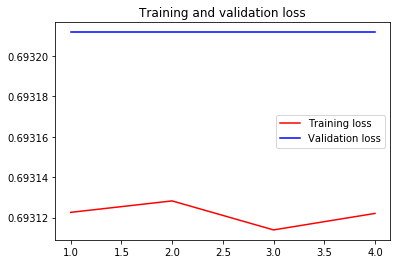

In [37]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [66]:
scores = model.predict_generator(test_gen, steps=test_steps)

In [68]:
for j,i in enumerate(scores):
    #print(i)
    print(i>0.5, f_data_test_y[j])

[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1


[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1


[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0


[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1


[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0


[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0


[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0


[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1


[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1


[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0


[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0


[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1


[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0


[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1


[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1


[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0


[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0


[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1


[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1


[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0


[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0


[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1


[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0


[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 0
[ True] 0
[ True] 0
[ True] 1
[ True] 0
[ True] 0
[ True] 1
[ True] 1
[ True] 0
[ True] 1
[ True] 0
[ True] 1
[ True] 1


KeyboardInterrupt: 

In [64]:
np.sum(scores<0.5)

0

In [201]:
dx = scores[0] - test_y[0]
scores_dx = scores - dx
dx

array([0.00191043])

In [62]:
print(scores[10][0])
print(test_y[10])

1.093334
1.0926


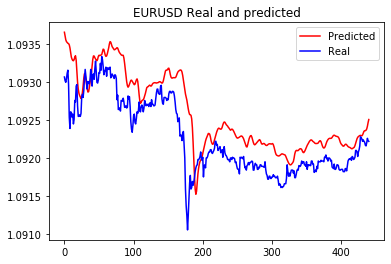

In [59]:
#### from matplotlib import pyplot as plt
plt.plot(range(len(scores)), scores, 'r', label='Predicted')
plt.plot(range(test_steps), test_y, 'b', label='Real')
plt.legend(['Predicted', 'Real'])
plt.title('EURUSD Real and predicted')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(scores)), scores, 'r', label='Predicted')
#plt.legend(['Predicted', 'Real'])
plt.title('EURUSD Predicted')
plt.show()

In [59]:
model.save_weights('weights.last.hdf5')